# Text Detection

https://mindee.github.io/doctr/

https://github.com/mindee/doctr/tree/main/references/detection

https://mindee.com/blog/vin-extraction-with-doctr/

https://mindee.github.io/doctr/using_doctr/using_models.html


In [17]:
%matplotlib inline
import os

os.environ['USE_TF'] = '1'
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

predictor = ocr_predictor(pretrained=True)

In [18]:
import xml.etree.ElementTree as ET
import numpy as np
import random
import hashlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ROOT_FOLDER_PREFIX = '../../'


def plot_bounding_box(line):
    img = plt.imread('../' +line.form_img_path_y)

    fig, ax = plt.subplots(figsize=(20,15))
    fig.figsize=(20,10)
    ax.imshow(img, cmap='gray')

    ax.add_patch(
        patches.Rectangle(
            (line.x-8, line.y-8),
            line.w+16,
            line.h+16,
            fill=False,
            color = 'red'      
        ) ) 
    plt.axis('off')
    plt.show()



In [19]:
import pickle
import pandas as pd
import json 

df = pd.read_pickle('../../pickle/df.pickle')
df.head()

,index,word_id,gray_level,x,y,w,h,tag,transcription,word_img_path,...,form_id,writer_id,text_id,number_of_sentences,word_seg,total_lines,correct_lines,total_words,correct_words,form_img_path_y
0,0,a01-000u-00-00,154,408,768,27,51,AT,A,../data/words/a01/a01-000u/a01-000u-00-00.png,...,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png
1,1,a01-000u-00-01,154,507,766,213,48,NN,MOVE,../data/words/a01/a01-000u/a01-000u-00-01.png,...,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png
2,2,a01-000u-00-02,154,796,764,70,50,TO,to,../data/words/a01/a01-000u/a01-000u-00-02.png,...,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png
3,3,a01-000u-00-03,154,919,757,166,78,VB,stop,../data/words/a01/a01-000u/a01-000u-00-03.png,...,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png
4,4,a01-000u-00-04,154,1185,754,126,61,NPT,Mr.,../data/words/a01/a01-000u/a01-000u-00-04.png,...,a01-000u,000,a01,2,prt,7,5,52,36,../data/formsA-D/a01-000u.png


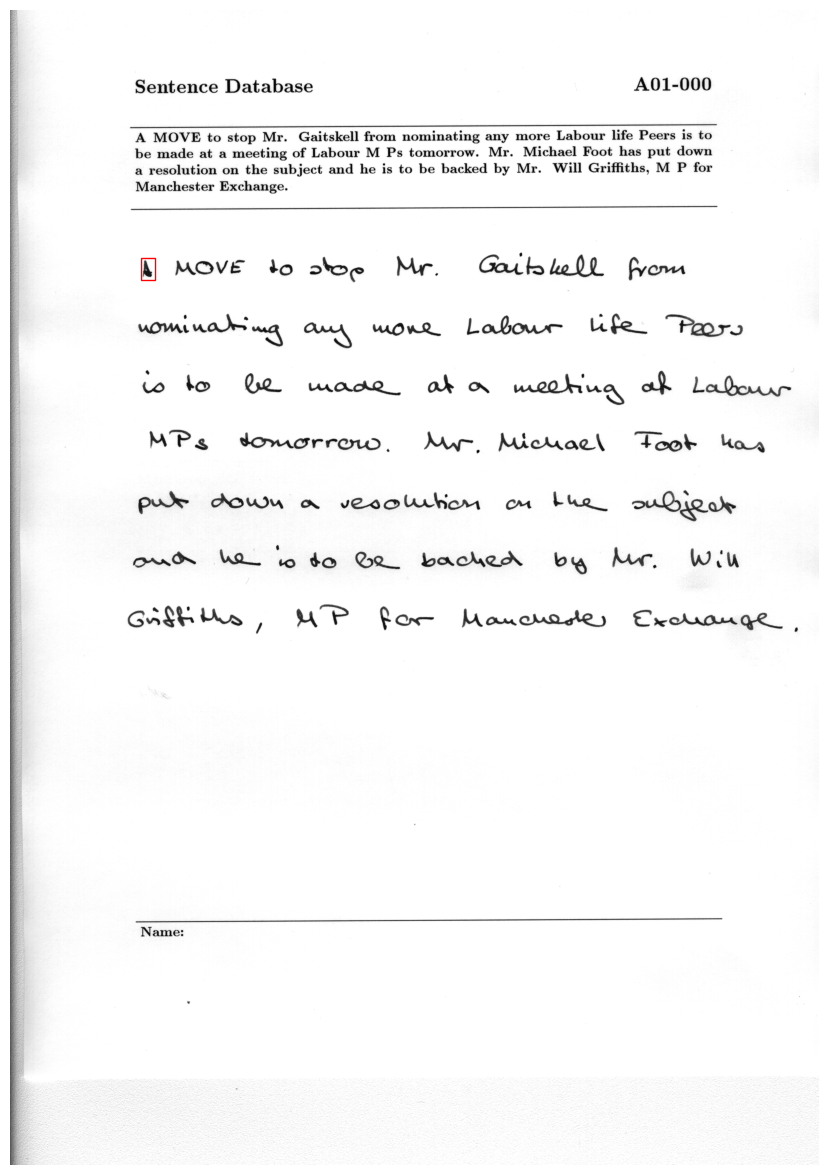

In [20]:
plot_bounding_box(df.iloc[0])

## Building structure

In [23]:
import random
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

rs = RandomState(MT19937(SeedSequence(42)))

random.seed(42)

train_img_dict = {}
val_img_dict = {}

IMG_DIM_ATTR_LABEL = 'img_dimensions'
IMG_HASH_ATTR_LABEL = 'img_hash'
POLYGON_ATTR_LABEL = 'polygons'
IS_TRAIN_ATTR_LABEL = 'is_train'

# def get_doctr_object():

# def decision(probability):
#     return random.random() < probability
def get_img_hash(img_arr):
    # return hashlib.sha256(img_arr)
    return hashlib.sha256(img_arr).hexdigest()

i = 0
# nb_images = 5000
nb_images = len(df)
for index, row in df.iterrows():
    # i += 1
    # if i > nb_images:
    #     break
        
    x = row.x
    y = row.y
    width = row.w
    height = row.h
    form_id = '../' + row.form_id
    form_img_path = '../' + row.form_img_path_y
    form_img_arr = plt.imread(form_img_path)

    is_train = index < int(nb_images * 0.8)

    box_coordinates = [
        [x, y],
        [x + width, y],
        [x + width, y + height],
        [x, y + height]
    ]

    form_img_filename = row.form_id + '.png'
    form_img_filename = form_img_filename.split('/')[-1]
    if is_train:
        future_img_path = 'text_detection_train/'
        train_img_dict[form_img_filename] = {
            # 'img_name': form_img_filename,
            # 'img_name': form_img_path,
            IMG_DIM_ATTR_LABEL: form_img_arr.shape,
            IMG_HASH_ATTR_LABEL: get_img_hash(form_img_arr),
            POLYGON_ATTR_LABEL: [],
            # IS_TRAIN_ATTR_LABEL: True
        }
        train_img_dict[form_img_filename][POLYGON_ATTR_LABEL].append(box_coordinates)
    else: 
        future_img_path = 'text_detection_val/'
        val_img_dict[form_img_filename] = {
            # 'img_name': form_img_filename,
            # 'img_name': form_img_path,
            IMG_DIM_ATTR_LABEL: form_img_arr.shape,
            IMG_HASH_ATTR_LABEL: get_img_hash(form_img_arr),
            POLYGON_ATTR_LABEL: [],
            # IS_TRAIN_ATTR_LABEL: False
        }
        val_img_dict[form_img_filename][POLYGON_ATTR_LABEL].append(box_coordinates)

with open("text_detection_train/labels.json", "w") as outfile:
    json.dump(train_img_dict, outfile, indent=4, sort_keys=False)
with open("text_detection_val/labels.json", "w") as outfile:
    json.dump(val_img_dict, outfile, indent=4, sort_keys=False)


Document(
  (pages): [Page(
    dimensions=(3542, 2479)
    (blocks): [
      Block(
        (lines): [Line(
          (words): [
            Word(value='!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', confidence=1.0),
            Word(value='!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', confidence=1.0),
          ]
        )]
        (artefacts): []
      ),
      Block(
        (lines): [Line(
          (words): [Word(value='!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', confidence=1.0)]
        )]
        (artefacts): []
      ),
    ]
  )]
)


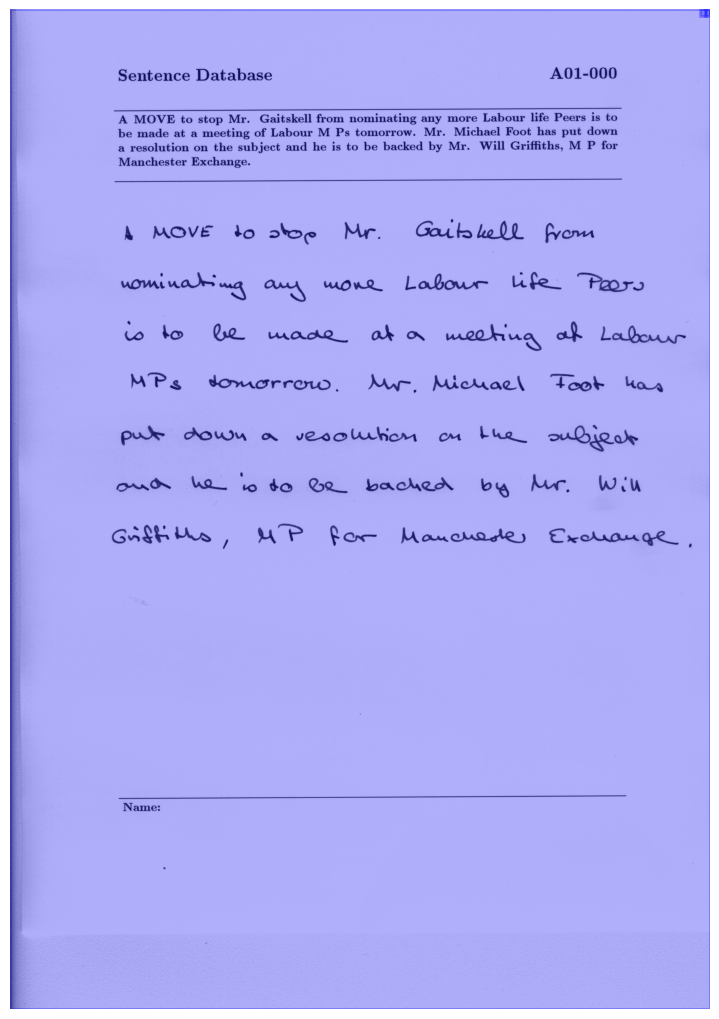

In [15]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# DET_CKPT = "db_resnet50_20221121-085413/weights"
DET_CKPT = "db_resnet50_20221129-112940/weights"
# DET_CKPT = "db_resnet50_20221129-112940/weights.data-00000-of-00001"

model = ocr_predictor(det_arch='db_resnet50', reco_arch='sar_resnet31', pretrained=True)
model.det_predictor.model.load_weights(DET_CKPT)

# Namespace(amp=False, arch='db_resnet50', batch_size=2,
#  epochs=1, eval_straight=False, find_lr=False, 
#  freeze_backbone=False, input_size=1024, lr=0.001,
#   name=None, pretrained=False, push_to_hub=False, 
#   resume=None, rotation=False, show_samples=False, 
#   test_only=False, train_path='text_detection_train', 
#   val_path='text_detection_val', wb=False, workers=None)
doc = DocumentFile.from_images("../../data/formsA-D/a01-000u.png")
result = model(doc)


print(result)
text = ''
for page in result.pages:
    for block in page.blocks:
        for line in block.lines:
            text += " ".join([word.value for word in line.words])
            text += "\n"
# Display the detection and recognition results on the image
result.show(doc)


# Test without pretraining

In [9]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

model = ocr_predictor(
    det_arch = 'db_resnet50',    
    reco_arch = 'crnn_vgg16_bn', 
    pretrained = True
)

doc = DocumentFile.from_images("../../data/formsA-D/a01-000u.png")
result = model(doc)
text = ''
for page in result.pages:
    for block in page.blocks:
        for line in block.lines:
            text += " ".join([word.value for word in line.words])
            text += "||"
            # text += "\n||"
# result.show(doc)
# print(result)
print(text)


Sentence Database
A01-000
A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to
be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down
a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for
Manchester Exchange.
A MOVE to stor
Mr.
Gaits kell from
uominahing any wOn& Labour Life Peors
6 to
MPS
lie uaco at a ueeting af Labour
sondrrow.
M. Michael toot has
put dowu a vesouhion CM Lhe oubieoe
ono ho vo - do B2 bacheo b4 Nur.
Wiu
Gnek ws,
MP for Maucuades Cxcuauge
Name:

